# Notebook for creating some of the main and supplementary figures for manuscript

## Import necessary modules

In [29]:
import os, scipy, pickle, platform, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib

from AaltoAtoms import CircCorralData, Spec, analyze_data, get_old_Ag_Co_corrals, fit_and_plot_functional_curve
from AaltoAtoms import show_waterfall, imshow_dIdV_vs_r
from AaltoAtoms.utils import labellines

from AaltoAtoms.Kondo_data_analysis.analyze_data import fit_and_plot_functional_curve
from AaltoAtoms.Kondo_data_analysis.analyze_data import plot_radial_width_dependence
from AaltoAtoms.Kondo_data_analysis.report_data import create_Co_cache, show_Co_waterfall, create_Ag_cache, show_Ag_waterfall, load_data, save_data
from AaltoAtoms.Kondo_data_analysis.report_data import fit_phenomenological_model
from AaltoAtoms.Kondo_data_analysis import data_array
from AaltoAtoms.utils.particle_in_a_box import get_modes, mstar

import matplotlib.font_manager
from importlib import reload
from scipy.signal import decimate
from matplotlib.colors import LogNorm
from scipy.interpolate import interp2d
from itertools import combinations, repeat
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

## Enable interactive plotting

In [2]:
%matplotlib notebook

## Import the data

In [3]:
sys.modules['data_array'] = data_array
basepath = r"/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data"
homedir = r"/Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis"
Co_Co_data_loc = os.path.join(basepath,'Co_Co_data.pickle')
Co_Ag_data_loc = os.path.join(basepath,'Co_Ag_data.pickle')

from data_array import Co_Ag_corrals
from data_array import H2Pc_corrals_edge, H2Pc_corrals_center

In [4]:
#save_data(Co_Co_data_loc, Co_Ag_data_loc, showfig=True)
Co_Co_data, Co_Ag_data = load_data(Co_Co_data_loc, Co_Ag_data_loc)

In [5]:
from collections import namedtuple

fields =  ['datfile', 'height_percentile','vertfile','marker1','marker2', "dataclipmin", "dataclipmax", "fit_order", "edge_cutoff", "chan", "type_fit"]
corralspectrum = namedtuple('corralspectrum', fields, defaults=(None,)*len(fields))
from AaltoAtoms.Kondo_data_analysis.report_data import show_current_param_fit_result

## Example dataset: corral and dI/dV spectrum

<IPython.core.display.Javascript object>


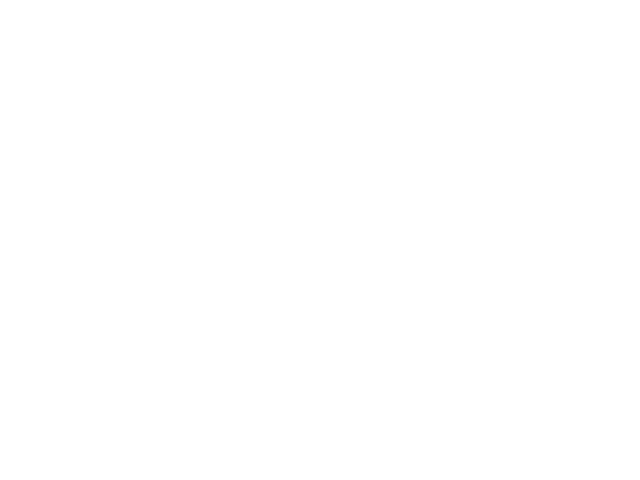

	30 centroids
	Max height guess different from Gaussian fit on average by: 0.77 Å


<IPython.core.display.Javascript object>


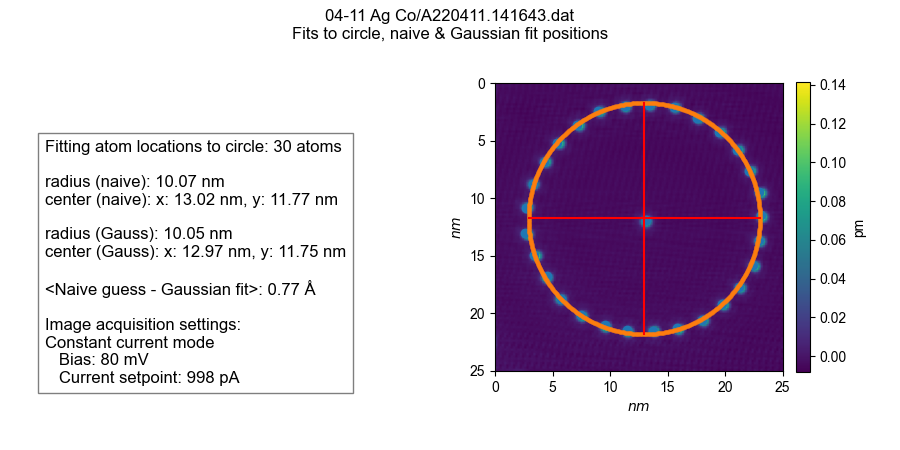

	 04-11 Ag Co/A220411.141643.dat
	Central atom from Naive fit:  10.070085112285442 [66.58917877 60.21236098]
	Central atom from Gauss fit:  10.054986768021092 [66.35770905 60.10063295]


<IPython.core.display.Javascript object>


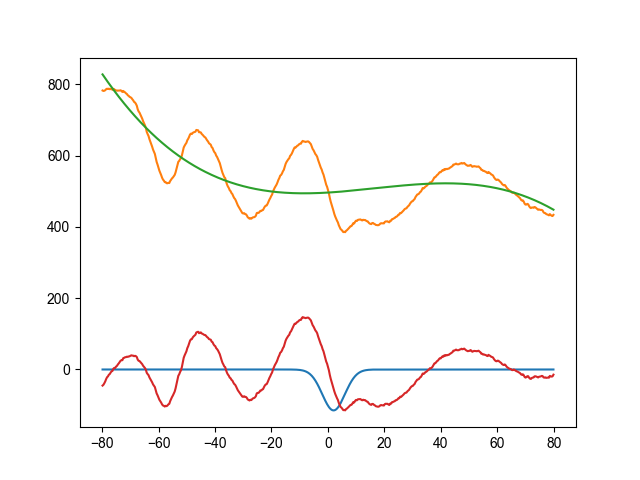

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e774220>, 3), {}] 
		took: 0.0393 sec


<IPython.core.display.Javascript object>


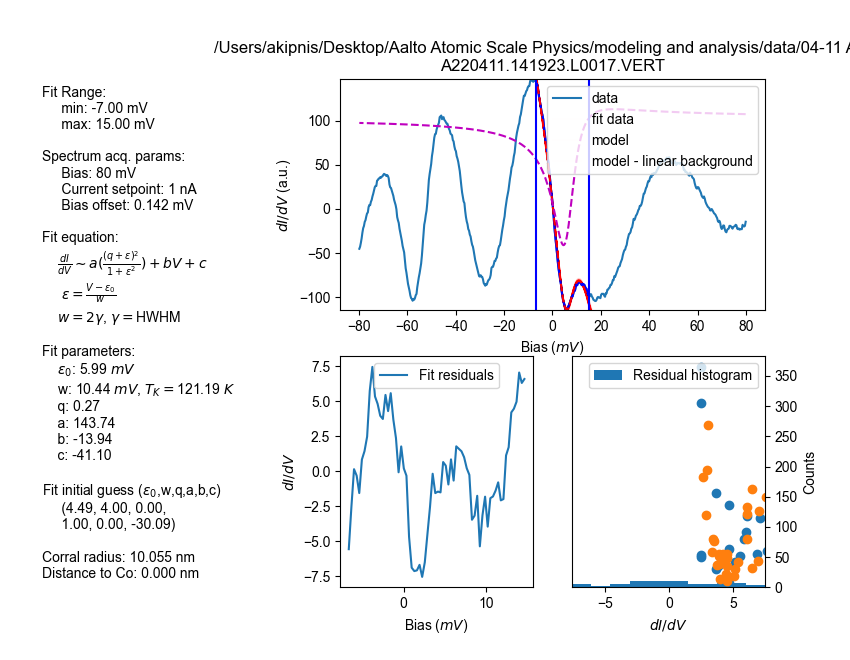

[5.92380586e-02 9.23718206e-02 2.12751484e-03 1.20356640e+01
 2.34155548e-01 8.18407109e+00]
[2023-11-27 10:49:38.321923]:
	 /Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data/04-11 Ag Co/A220411.141923.L0017.VERT
...
saved figure at /Users/akipnis/Desktop/Aalto Atomic Scale Physics/modeling and analysis/data/04-11 Ag Co/A220411.141923.L0017_fit_residual.png
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e774220>,), {'marker1': -7, 'marker2': 15, 'type_fit': 'default', 'showfig': True, 'e0_fixed_val': nan, 'actual_radius': 10.054986768021092}] 
		took: 3.8518 sec


In [30]:
#c = corralspectrum("04-11 Ag Co/A220411.133438.dat", 98, "04-11 Ag Co/A220411.134351.L0013.VERT", -3, 30, -32, 60, None, None, 'default')
c = corralspectrum("04-11 Ag Co/A220411.141643.dat", 99, "04-11 Ag Co/A220411.141923.L0017.VERT", -7, 15, -80, 80, 3, None, 'default')
#c = corralspectrum("04-11 Ag Co/A220411.173719.dat", 99, "04-11 Ag Co/A220411.174011.VERT", -12, 15, -25, 50, 3)

r = show_current_param_fit_result(c)


## Create the dataset for the w(r) plot

In [31]:
Co = np.array([[c['radius'], c['width']] for c in Co_Co_data]).T
Ag = np.array([[c['radius'], c['width']] for c in Co_Ag_data]).T

<IPython.core.display.Javascript object>


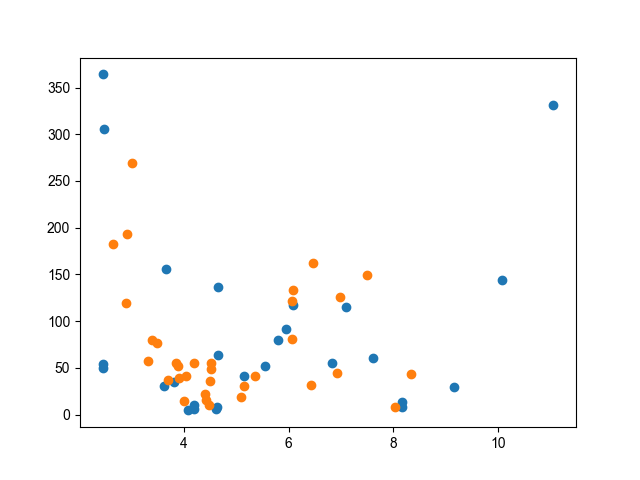

In [33]:
plt.figure()
plt.scatter(*np.array([[c['radius'], c['fano_fit_result'][0][3]] for c in Co_Ag_data]).T)
plt.scatter(*np.array([[c['radius'], c['fano_fit_result'][0][3]] for c in Co_Co_data]).T)

<IPython.core.display.Javascript object>


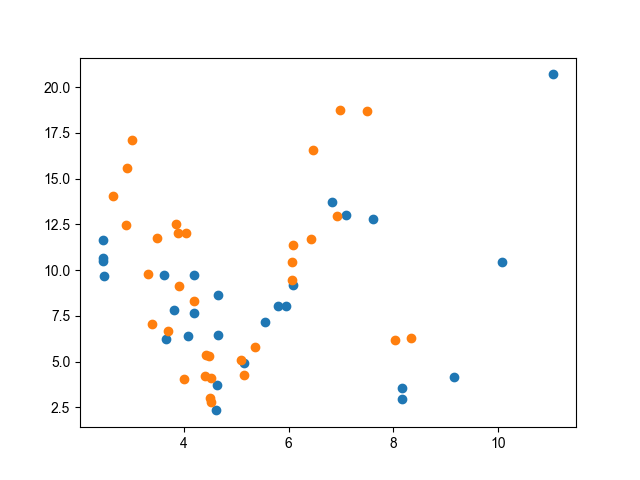

In [34]:
plt.figure()
plt.scatter(*Ag)
plt.scatter(*Co)

## First try at fitting the phenomenological model. More fitting trials can be found in other notebook

<IPython.core.display.Javascript object>


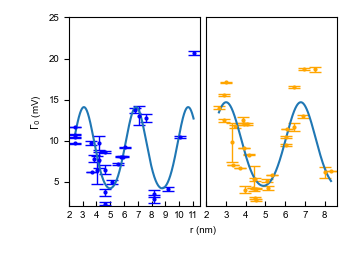



Ag results
[3667489.0810272447, 51829.15605677141, 111950.97860451307, 0.13065185161432552]
A: 1.986809 pm 3667489.081027 
Jb: 0.558896 pm 51829.156057 meV
Js: 0.060648 pm 111950.978605 meV
d1: 1.161321 pm 0.130652 


Co results
[4430988.83780191, 37922.88885621077, 81913.43483846035, 0.1532543288002574]
A: 2.544901 pm 4430988.837802 
Jb: 0.570186 pm 37922.888856 meV
Js: 0.047046 pm 81913.434838 meV
d1: 1.282590 pm 0.153254 


In [456]:
%matplotlib notebook
def w(r, A, jb=0.53,
            js=0.21,
            d1=-0.27,
            ):
    """
    Model for Kondo resonance width as a function of corral radius r
    """
    rhob = 0.27 # 1/eV
    rhos0 = 0.125 # 1/eV
    D = 4480
    k=0.83
    # A=3.2
    return D*np.exp(-1./(jb*rhob+js*rhos0*(1+A*np.cos(2*k*r+d1))))

def fit_and_plot_functional_curve(radius_array: list,
                                  width_array: list,
                                  bounds: list=None,
                                  p0: list=None,
                                  fixed: dict=None,
                                  sigma: list=None,
                                  show_Li_fit=True,
                                  show_isolated_Co=True):
    """

    """
    param_dict = {
            'A':'',
            'Jb':'meV',
              'Js':'meV',
              'd1':'',
              #'k':'nm^-1',
              }

    ###
    params, pcov = scipy.optimize.curve_fit(w,
                                      radius_array,
                                      width_array,
                                      p0,
                                      bounds=bounds,
                                      maxfev=10000,
                                      #sigma=sigma,
                                      absolute_sigma=False,
                                      #loss='linear'
                                           )

    ###

    rng = np.arange(min(list(radius_array)),max(radius_array),0.01)
    line = plt.plot(rng, np.array([w(x,*params) for x in rng]))

    #https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
    error = []
    for i in range(len(params)):
        try:
            error.append(np.sqrt(pcov[i][i]))
        except Exception as e:
            print(e)
            error.append(0.00)
    print(error)
    for n, p in enumerate(list(param_dict.keys())):
        print("%s: %lf pm %lf %s" %(p, params[n], error[n], param_dict[p]))
    return params, pcov, line

def fit_phenomenological_model():
    """
    Left (blue) - Co wall data
    Right (orange) - Ag wall data
    """
    bounds = {
        'A': (0,5),
        'Jb': (0.,0.8),
        'Js': (0,1),
        'd1': (0, 2*np.pi),
        #'k': (0.80,0.86),
    }

    p0 = {
        'A': 3,
        'Jb': 0.5,
        'Js': 0.05,
        'd1': 0.27,
        #'k': 0.83,
    }

    p0 = [p0[l] for l in list(p0.keys())]
    bounds = np.array([bounds[b] for b in list(bounds.keys())]).T
    
    cm = 1/2.54  # centimeters in inches
    fig = plt.figure(figsize=(9*cm,6.6*cm))
    ax = fig.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax1 = fig.add_subplot(122)
    ax2 = fig.add_subplot(121)#, sharey=ax1)
    ax.set_xlabel("r (nm)", size=7)
    all_data = np.concatenate([Co_Ag_data, Co_Co_data], axis=0)

    # use scatter or errobar ? errorbars are very small for fits
    # plt.scatter(*np.array([c[0:2] for c in Co_Ag_data]).T, label="Ag walls", marker="D")
    # plt.scatter(*np.array([c[0:2] for c in Co_Co_data]).T, label="Co walls", marker="s")
    msize = 2
    capsize = 4
    elinewidth = 1
    kwargs = {'fmt':"o",
              'markersize':msize,
              'solid_capstyle':'butt',
              'capsize':capsize,
              'elinewidth':elinewidth,
              'capthick':elinewidth}
    
    ###
    r = np.array([[c['radius'], c['width']] for c in Co_Co_data]).T
    kwargs["c"]= "orange"
    kwargs["label"] = "Co walls"
    Co_wall_err = [c['fano_fit_result'][1][1][1] for c in Co_Co_data]
    ax1.errorbar(*r, yerr=Co_wall_err, **kwargs)
    
    r = np.array([[c['radius'], c['width']] for c in Co_Ag_data]).T
    kwargs["c"]= "b"
    kwargs["label"] = "Ag walls"
    Ag_wall_err = [c['fano_fit_result'][1][1][1] for c in Co_Ag_data]
    ax2.errorbar(*r, yerr=Ag_wall_err, **kwargs)
    
    font_kwargs = {'family':'arial', 'style':'normal', 'size':7, 'weight':'normal', 'stretch':'normal'}
    _font = matplotlib.font_manager.FontProperties(**font_kwargs)
    ###
    
    Co = np.array([[c['radius'], c['width']] for c in Co_Co_data]).T
    Ag = np.array([[c['radius'], c['width']] for c in Co_Ag_data]).T
    f = np.concatenate([Co, Ag], axis=1)
    plt.gcf().axes[0].tick_params(direction="in")
    plt.gcf().axes[1].tick_params(direction="in")

    #https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
    w_sigma = [c['fano_fit_result'][1][1][1] for c in Co_Ag_data]

    print("\n\nAg results")
    plt.sca(ax2) # set current axis
    kwargs = {"bounds": bounds,
              "p0": p0,
              "show_Li_fit": False,
              "show_isolated_Co": False,
              #"sigma": w_sigma
              }
    params, pcov, line = fit_and_plot_functional_curve(*Ag, **kwargs)
    kwargs = {'mean': params, 'cov': pcov, 'allow_singular': False}
    '''try:
        nsamples = 200
        alpha = 0.005
        r_step = 0.05
        multivar = scipy.stats.multivariate_normal(**kwargs)
        rmin = min(Ag[0])
        rmax = max(Ag[0])
        for i in range(nsamples):
            gauss_sampled_vals = multivar.rvs()
            radius_range = np.arange(rmin, rmax, r_step)
            args = radius_range, w(radius_range, *gauss_sampled_vals)
            ax2.plot(*args, alpha=alpha, color='blue', zorder=0)
    except np.linalg.LinAlgError as e:
        print(e)'''
    plt.gcf().axes[0].tick_params(direction="in")
    plt.gcf().axes[1].tick_params(direction="in")

    print("\n\nCo results")
    plt.sca(ax1) # set current axis so fit_and_plot_functional_curve plots on it
    kwargs = {"bounds": bounds,
              "p0": p0,
              "show_Li_fit": False,
              "show_isolated_Co": False}
    w_sigma = [c['fano_fit_result'][1][1][1] for c in Co_Co_data]
    kwargs["sigma"] = w_sigma
    params, pcov, line = fit_and_plot_functional_curve(*Co, **kwargs)
    kwargs = {'mean':params, 'cov':pcov, 'allow_singular':False}
    '''try:
        multivar = scipy.stats.multivariate_normal(**kwargs)
        rmin = min(Co[0])
        rmax = max(Co[0])
        for i in range(nsamples):
            gauss_sampled_vals = multivar.rvs()
            radius_range = np.arange(rmin, rmax, r_step)
            args = radius_range, w(radius_range, *gauss_sampled_vals)
            ax1.plot(*args, alpha=alpha, color='orange', zorder=0)
    except np.linalg.LinAlgError as e:
        print(e)
'''    
    ax1.set_ylim(2,25)
    ax2.set_ylim(2,25)
    xticks = ax2.set_xticks(np.arange(2,12,1), fontsize=7,fontproperties=_font)
    xticks = ax1.set_xticks(np.arange(2,9,1), fontsize=7,fontproperties=_font)
    yticks = ax1.set_yticks(np.arange(5,25,5), fontsize=7, fontproperties=_font)
    ylabel = ax2.set_ylabel(r"$\Gamma_0$ (mV)")
    ylabel.set_font_properties(_font)
    ax2.tick_params(axis='y', which='both', bottom=False, top=False,
                                            labelbottom=False, right=False,
                                            reset=True, labelsize=7)
    ax1.tick_params(axis='y', which='both', bottom=False, left=False,
                                            labelleft=False, right=False,
                                            labelright=False)
    ax1.tick_params(axis='x',  labelsize=7, direction='in')
    ax2.tick_params(axis='x',  labelsize=7, direction='in')
    plt.tight_layout()
    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.05,
                        hspace=None)
    
fit_phenomenological_model()

In [411]:
def w_jb_eq_js(r, jb=0.53,
            #js=0.21,
            d1=0.27,
            ):
    """
    Simple model for Kondo resonance width as a function of corral radius r
    """
    rhob = 0.27 # 1/eV
    rhos0 = 0.125 # 1/eV
    D = 4480
    k=0.83
    A=3.2
    return D*np.exp(-1./(jb*rhos0*(1+A*np.cos(2*k*r+d1))))

In [ ]:
Co = np.array([[c['radius'], c['width'], c['fano_fit_result'][1][1][1]] for c in Co_Co_data]).T
Ag = np.array([[c['radius'], c['width'], c['fano_fit_result'][1][1][1]] for c in Co_Ag_data]).T
     
p0=   {'Jb': 0.3,
       # 'Js': 0.05,
        'd1': 0.4,
        #'k': 0.83,
    }
bounds =     bounds = {
        'Jb': (0.,1),
        #'Js': (0,1),
        'd1': (0, 2*np.pi),
        #'k': (0.80,0.86),
    }
p0 = [p0[l] for l in list(p0.keys())]
bounds = np.array([bounds[b] for b in list(bounds.keys())]).T
params, pcov = scipy.optimize.curve_fit(w_jb_eq_js,
                                      Ag[0],
                                      Ag[1],
                                      p0,
                                      bounds=bounds,
                                      #maxfev=10000,
                                      sigma=None,#Ag[2],
                                      #absolute_sigma=False,
                                      loss='linear'
                                           )
plt.figure()
plt.scatter(*Ag[0:2,])
rng = np.arange(min(list(Ag[0])),max(Ag[0]),0.01)
line = plt.plot(rng, np.array([w(x,*params) for x in rng]))
plt.plot()

## Create the waterfall plots (main text figure)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


04-01/A220401.010342.dat
corralspectrum(datfile='04-01/A220401.010342.dat', height_percentile=99, vertfile='04-01/A220401.011026.L0125.VERT', marker1=-2, marker2=40, dataclipmin=-5, dataclipmax=40, fit_order=3, edge_cutoff=None, chan=None, type_fit=None)


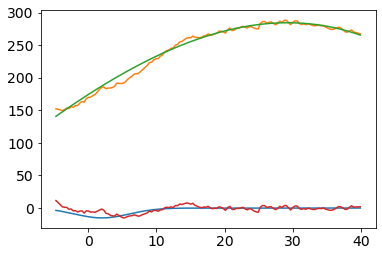

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>, 3), {}] 
		took: 0.1805 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>,), {'marker1': -2, 'marker2': 40, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0370 sec
4-12 Co-Co/A220412.224607.dat
corralspectrum(datfile='4-12 Co-Co/A220412.224607.dat', height_percentile=99, vertfile='4-12 Co-Co/A220412.224743.VERT', marker1=-10, marker2=15, dataclipmin=-40, dataclipmax=45, fit_order=None, edge_cutoff=None, chan=None, type_fit=None)
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>,), {'marker1': -10, 'marker2': 15, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0470 sec
4-12 Co-Co/A2

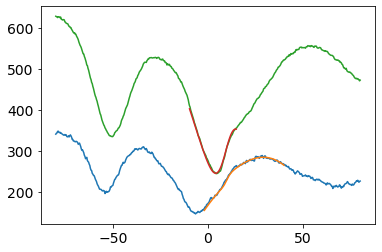

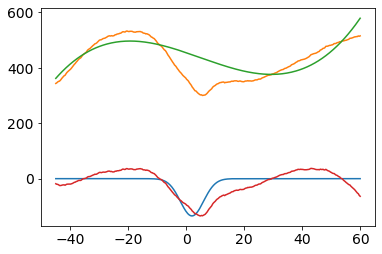

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>, 3), {}] 
		took: 0.2220 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>,), {'marker1': -15, 'marker2': 15, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0397 sec
4-12 Co-Co/A220412.183001.dat
corralspectrum(datfile='4-12 Co-Co/A220412.183001.dat', height_percentile=99, vertfile='4-12 Co-Co/A220412.184138.L0025.VERT', marker1=-10, marker2=20, dataclipmin=None, dataclipmax=None, fit_order=None, edge_cutoff=2.5, chan=None, type_fit=None)
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10f297a90>,), {'marker1': -10, 'marker2': 20, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0171 sec
04-1

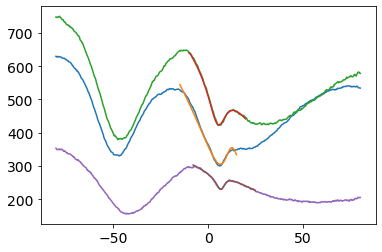

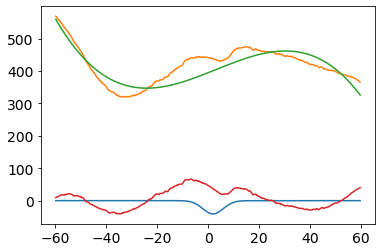

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>, 3), {}] 
		took: 0.2325 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>,), {'marker1': -10, 'marker2': 40, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0258 sec
04-04/A220404.160833.dat
corralspectrum(datfile='04-04/A220404.160833.dat', height_percentile=99, vertfile='04-04/A220404.160935.VERT', marker1=-10, marker2=15, dataclipmin=-20, dataclipmax=45, fit_order=3, edge_cutoff=None, chan=None, type_fit=None)


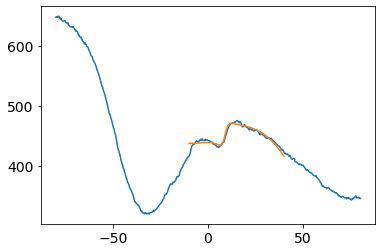

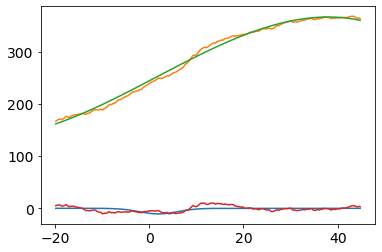

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>, 3), {}] 
		took: 0.2060 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>,), {'marker1': -10, 'marker2': 15, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0209 sec
04-14 Co Co/A220414.205921.dat
corralspectrum(datfile='04-14 Co Co/A220414.205921.dat', height_percentile=99, vertfile='04-14 Co Co/A220414.210247.VERT', marker1=0, marker2=13, dataclipmin=-60, dataclipmax=60, fit_order=3, edge_cutoff=None, chan=0, type_fit=None)


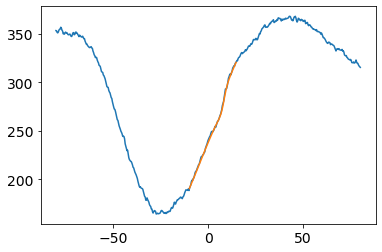

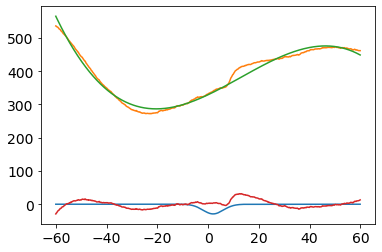

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>, 3), {}] 
		took: 0.2285 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>,), {'marker1': 0, 'marker2': 13, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0270 sec
4-12 Co-Co/A220412.160314.dat
corralspectrum(datfile='4-12 Co-Co/A220412.160314.dat', height_percentile=99, vertfile='4-12 Co-Co/A220412.160413.VERT', marker1=0, marker2=50, dataclipmin=0, dataclipmax=50, fit_order=3, edge_cutoff=None, chan=None, type_fit=None)


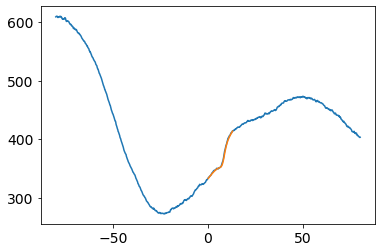

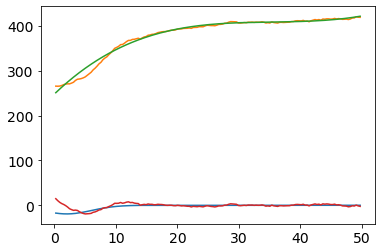

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>, 3), {}] 
		took: 0.2528 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131293fd0>,), {'marker1': 0, 'marker2': 50, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0496 sec
4-12 Co-Co/A220412.132510.dat
corralspectrum(datfile='4-12 Co-Co/A220412.132510.dat', height_percentile=99, vertfile='4-12 Co-Co/A220412.132822.L0017.VERT', marker1=-5, marker2=15, dataclipmin=-40, dataclipmax=40, fit_order=None, edge_cutoff=None, chan=None, type_fit='default')
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13237d070>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13237d070>,), {'marker1': -5, 'marker2': 15, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0619 sec
4-12 

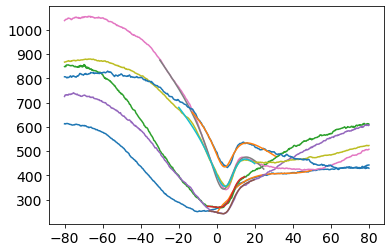

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


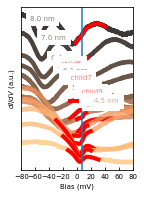

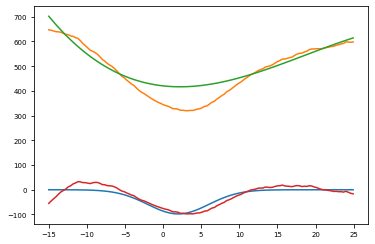

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130ae7220>, 3), {}] 
		took: 0.5759 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130ae7220>,), {'marker1': -15, 'marker2': 25, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0883 sec
	30 centroids
	Max height guess different from Gaussian fit on average by: 0.82 Å
corralspectrum(datfile='04-11 Ag Co/A220411.141643.dat', height_percentile=99, vertfile='04-11 Ag Co/A220411.141923.L0017.VERT', marker1=-7, marker2=15, dataclipmin=-80, dataclipmax=80, fit_order=3, edge_cutoff=None, chan=None, type_fit=None)


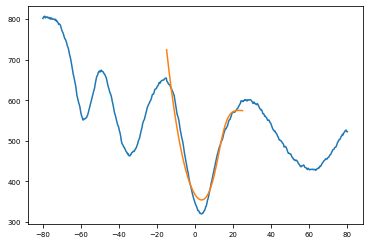

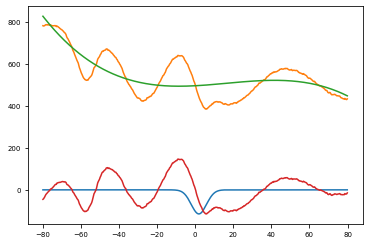

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13217b070>, 3), {}] 
		took: 0.2410 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13217b070>,), {'marker1': -7, 'marker2': 15, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0359 sec
	30 centroids
	Max height guess different from Gaussian fit on average by: 0.85 Å
corralspectrum(datfile='04-11 Ag Co/A220411.145437.dat', height_percentile=99, vertfile='04-11 Ag Co/A220411.145852.VERT', marker1=-2, marker2=15, dataclipmin=None, dataclipmax=None, fit_order=None, edge_cutoff=None, chan=None, type_fit=None)
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x132195280>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x132195280>,), {'marker1': -2, 'marker2': 15, 'showfig': False, 'actual_radius': None, 't

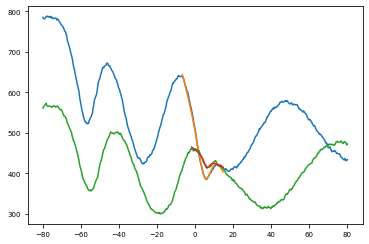

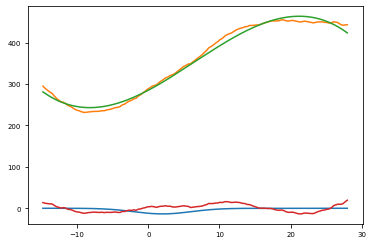

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13241f0d0>, 3), {}] 
		took: 0.2284 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13241f0d0>,), {'marker1': -2, 'marker2': 12, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0196 sec
	30 centroids
	Max height guess different from Gaussian fit on average by: 0.92 Å
corralspectrum(datfile='04-11 Ag Co/A220411.161126.dat', height_percentile=99, vertfile='04-11 Ag Co/A220411.161806.L0017.VERT', marker1=-2, marker2=12, dataclipmin=None, dataclipmax=None, fit_order=None, edge_cutoff=None, chan=None, type_fit=None)
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13262e550>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13262e550>,), {'marker1': -2, 'marker2': 12, 'showfig': False, 'actual_radius': No

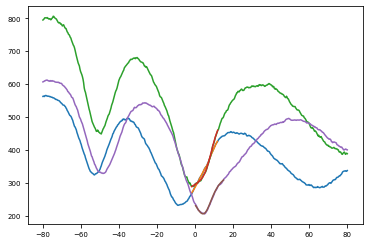

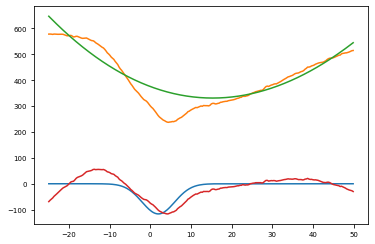

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1321958b0>, 3), {}] 
		took: 0.2662 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1321958b0>,), {'marker1': -12, 'marker2': 15, 'showfig': False, 'actual_radius': None, 'type_fit': 'default'}] 
		took: 0.0467 sec
	28 centroids
	Max height guess different from Gaussian fit on average by: 0.85 Å
corralspectrum(datfile='04-11 Ag Co/A220411.183528.dat', height_percentile=99, vertfile='04-11 Ag Co/A220411.183838.VERT', marker1=-13, marker2=30, dataclipmin=None, dataclipmax=None, fit_order=None, edge_cutoff=None, chan=None, type_fit=None)
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1327b73a0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1327b73a0>,), {'marker1': -13, 'marker2': 30, 'showfig': False, 'actual_radius': None,

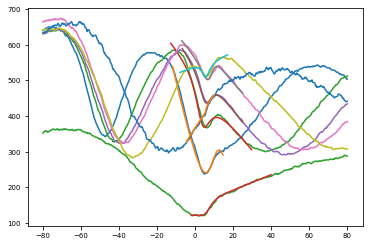

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


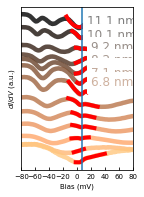

In [4]:
Co_waterfall_cache = create_Co_cache()
show_Co_waterfall(Co_waterfall_cache)
Ag_waterfall_cache = create_Ag_cache()
show_Ag_waterfall(Ag_waterfall_cache, 0, 1)

## Look at the interpolated spectra as a function of corral radius (supplementary text figure)

In [70]:
# %% Show the interpolated spectra (i.e. SI figs 3, 4 )
def show_interpolated_spectra(data: str, interpolate:bool=True):
    imshow_dIdV_vs_r(data, 
                    downsample=False,
                    interpolate=interpolate, 
                    nm_step=0.1,
                    mV_step=0.1,
                    norm_mV=-67, 
                    norm_to_one=False)
    
    plt.gcf().savefig("/Users/akipnis/Desktop/Co.png")

In [17]:
def imshow_dIdV_vs_r(dataset: list,
                    downsample: bool=False,
                    interpolate:bool=False,
                    norm_mV: float = -75,
                    mV_step:float = 1,
                    nm_step: float = 0.5,
                    enforce_conformity: bool = True,
                    norm_to_one: bool = False,
                    cmap_str="plasma",
                    savefig: bool =False,
                    fig_path: str ="", 
                    ms = 0.4, 
                    radius_offset=0,
                    e0=0.067) -> None:
    """

    """

    from scipy.interpolate import griddata
    import itertools
    from itertools import repeat
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib
    from matplotlib.ticker import MaxNLocator
    import matplotlib.font_manager
    cm = 1/2.54  # centimeters in inches
    fig = plt.figure(figsize=(8*cm,8*cm))
    #plt.imshow([list(reversed(c[2]/c[2][np.argmin(abs(c[3]-7))])) for c in dataset if len(c[3])==502 and c[3][0]==80 and c[3][-1]==-80], aspect=20, interpolation=None, extent=[-80,80, 2, 10])
    if enforce_conformity:
        conforms = lambda x: len(x['bias_mv'])==502 and x['bias_mv'][0]==80 and x['bias_mv'][-1]==-80
        ds = [c for c in dataset if conforms(c)]
    else:
        ds = dataset
    # some data sets have 1002 points instead of 502 like the majority
    # so we have to downsample them to match the length
    # in order to plot them with the other ones in this 3D plot
    if downsample:
        d2 = [d for d in dataset if len(d['bias_mv'])==1002 and d['bias_mv'][0]==80]
        dIdV_downsampled = [np.append(d['dIdV'][::2],d['dIdV'][-1]) for d in d2]
        bias_downsampled = [np.append(d['bias_mv'][::2],d['bias_mv'][-1]) for d in d2]
        norm_vals_downsampled = [c[np.argmin(abs(bias_downsampled[n]-norm_mV))] for n,c in enumerate(dIdV_downsampled)]
        Z_downsampled = [d/norm_vals_downsampled[n] for n, d in enumerate(dIdV_downsampled)]

    norm_vals = [c['dIdV'][np.argmin(abs(c['bias_mv']-norm_mV))] for c in ds]
    X = ds[0]['bias_mv'] # bias (has to be same for all spectra!)
    Z = [c['dIdV']/norm_vals[n] for n,c in enumerate(ds)] # dI/dV signal
    Y = [c['radius'] for c in ds] # radii

    if norm_to_one:
        Z = [(z - min(z))/(max(z) - min(z)) for z in Z]


    if downsample and len(Z_downsampled) != 0:
        Y = np.append(Y, [c[0] for c in d2])
        Z = np.append(Z, Z_downsampled, axis=0)

    if interpolate:
        # plot the spectra on this new grid
        xstep = mV_step # "pixel size" in in mV
        ystep = nm_step # "pixel size" in nm
        xnew = np.arange(min(X), max(X)+xstep, xstep)
        ynew = np.arange(min(Y), max(Y), ystep)
        Xn, Yn = np.meshgrid(xnew, ynew)

        # center things with bias index
        create_pt = lambda x: list(zip(x['bias_mv']-x['Spec'].bias_offset, repeat(x['radius'])))
        pts = np.array([np.array(create_pt(d)) for d in ds])
        pts = pts.reshape(-1,2)

        Z = np.array(Z)
        levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
        args = np.array(pts), Z.reshape(-1, 2).flatten(), (Xn, Yn)
        gridZ = griddata(*args, method="linear")

        plt.pcolormesh(Xn, Yn, gridZ, cmap=plt.get_cmap(cmap_str))
    else:
        #pass
        plt.pcolormesh(X, Y, Z, cmap=plt.get_cmap(cmap_str), shading="gouraud")#, norm=LogNorm(), vmin=np.array(Z).min(), vmax=np.array(Z).max())
    r_range = np.arange(min(Y), max(Y), 0.1)

    # to get particle in a box eigenmodes analytically
    e0, e1, e2, e3 = get_modes(ms*scipy.constants.electron_mass,e0, (r_range-radius_offset)*1e-9, 4).T

    plt.plot(e0*1e3, r_range, color='black', linestyle='--')
    plt.plot(e1*1e3, r_range, color='black', linestyle='--')
    plt.plot(e2*1e3, r_range, color='black', linestyle='--')
    plt.plot(e3*1e3, r_range, color='black', linestyle='--')
    
    e0, e1, e2, e3 = get_modes(ms*scipy.constants.electron_mass, 0.067, (r_range)*1e-9, 4).T

    plt.plot(e0*1e3, r_range, color='black')
    plt.plot(e1*1e3, r_range, color='black')
    plt.plot(e2*1e3, r_range, color='black')
    plt.plot(e3*1e3, r_range, color='black')

    plt.xlim(-80,80)

    from matplotlib.font_manager import FontProperties
    plt.rcParams['font.sans-serif'] = ['Arial']
    # kwargs = {'family':'sans-serif', 'size':7, 'sans-serif': 'Arial'}
    font = {'family' : 'sans-serif','sans-serif': 'Arial',
        'size'   : 7}

    matplotlib.rc('font', **font)
    # _font = FontProperties(**kwargs)
    xlab = plt.xlabel("Bias (mV)")
    ylab = plt.ylabel("Corral radius (nm)")

    plt.gca().set_xticks([-60, -40, -20, 0, -20,-40,-60], fontname="Arial")
    # plt.gca().set_yticks([4,6,8,10]) 
    # plt.gca().set_xticklabels([-60, -40, -20, 0,-20,-40,-60], fontproperties=_font)
    # plt.gca().set_yticklabels([4,6,8,10], fontproperties=_font)
    # xticks = plt.xticks(fontproperties=_font)
    # yticks = plt.yticks(fontproperties=_font)
    # xlab.set_font_properties(_font)
    # ylab.set_font_properties(_font)
    # cbar = plt.colorbar()
    # cbar.ax.set_ylabel(r'$dI/dV$ (a.u.)', rotation=270)
    # cbar.ax.set_yticks([])

    if savefig:
        plt.savefig(fig_path, dpi=800)
    return fig

<IPython.core.display.Javascript object>


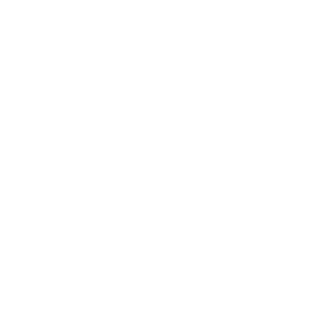

TypeError: tuple indices must be integers or slices, not str

In [21]:
%matplotlib notebook
f1 = imshow_dIdV_vs_r(H2Pc_corrals_center, 
                    downsample=False,
                    interpolate=True, 
                    nm_step=0.1,
                    mV_step=0.1,
                    norm_mV=-75, 
                      enforce_conformity=True,
                    norm_to_one=False, 
                    savefig=False,
                    ms = 0.4, 
                    radius_offset=0.8,
                    e0=0.060,
                    fig_path="/Users/akipnis/Desktop/Ag.pdf")
#plt.savefig("/Users/akipnis/Desktop/H2Pc.pdf")

<IPython.core.display.Javascript object>


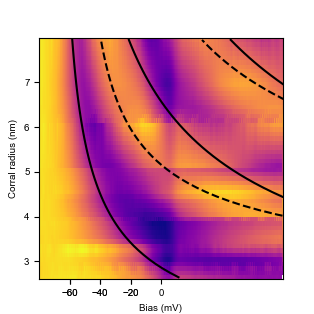

In [19]:

#plt.savefig("/Users/akipnis/Desktop/Ag.pdf")
f2 = imshow_dIdV_vs_r(Co_Co_data, 
                    downsample=False,
                    interpolate=True, 
                    nm_step=0.1,
                    mV_step=0.1,
                    norm_mV=-75, 
                    norm_to_one=False, 
                    savefig=False,
                      ms = 0.4, 
                    radius_offset=2.0,
                    e0=0.055,
                    fig_path="/Users/akipnis/Desktop/Co.pdf")
 

<IPython.core.display.Javascript object>


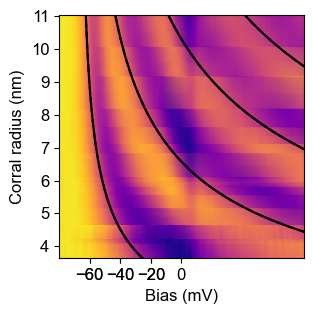

<IPython.core.display.Javascript object>


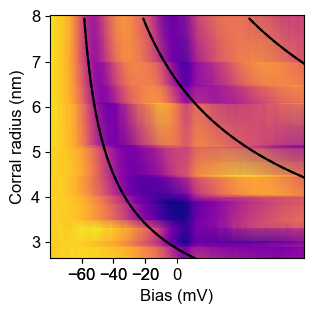

In [20]:
cm = 1/2.54


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig = imshow_dIdV_vs_r(Co_Ag_data)
#fig.set_figwidth(8*cm,)
fig.tight_layout()
#plt.savefig("/Users/akipnis/Desktop/Co_Ag.png", dpi=900)


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig = imshow_dIdV_vs_r(Co_Co_data)
#fig.set_figwidth(8*cm,)
fig.tight_layout()

#plt.savefig("/Users/akipnis/Desktop/Co_Co.png", dpi=900)


## Looking at the other parameters (e0, q, A, B, C) of Fano fit

(array([4., 3., 8., 4., 5., 2., 4., 1., 1., 1.]),
 array([ 4.7053357 ,  5.47449885,  6.243662  ,  7.01282514,  7.78198829,
         8.55115144,  9.32031458, 10.08947773, 10.85864087, 11.62780402,
        12.39696717]),
 [<matplotlib.patches.Polygon at 0x13118fdf0>])

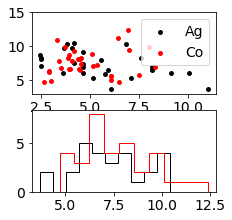

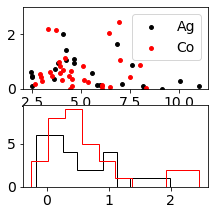

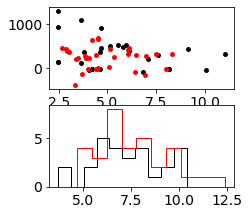

In [13]:
import matplotlib.pyplot as plt
cm = 1/2.54
fig, (a1, a2) = plt.subplots(2, figsize=(8.4*cm, 8.4*cm))
a1.scatter([c['radius'] for c in Co_Ag_data], [c['fano_fit_result'][0][0] for c in Co_Ag_data], c='black', s=15)
a1.scatter([c['radius'] for c in Co_Co_data], [c['fano_fit_result'][0][0] for c in Co_Co_data], c='red', s=15)
a1.set_ylim(3, 15)
a1.legend(["Ag", "Co"])
a2.hist([c['fano_fit_result'][0][0] for c in Co_Ag_data], histtype='step', color='black')
a2.hist( [c['fano_fit_result'][0][0] for c in Co_Co_data], histtype='step', color='red')
#plt.savefig("/Users/akipnis/Desktop/e0_variation.pdf")

fig, (a1, a2) = plt.subplots(2, figsize=(8.4*cm, 8.4*cm))
a1.scatter([c['radius'] for c in Co_Ag_data], [c['fano_fit_result'][0][2] for c in Co_Ag_data], c='black', s=15)
a1.scatter([c['radius'] for c in Co_Co_data], [c['fano_fit_result'][0][2] for c in Co_Co_data], c='red', s=15)
a1.set_ylim(0, 3)
a1.legend(["Ag", "Co"])
a2.hist([c['fano_fit_result'][0][2] for c in Co_Ag_data], histtype='step', color='black')
a2.hist( [c['fano_fit_result'][0][2] for c in Co_Co_data], histtype='step', color='red')
#plt.savefig("/Users/akipnis/Desktop/q_variation.pdf")

fig, (a1, a2) = plt.subplots(2, figsize=(8.4*cm, 8.4*cm))
a1.scatter([c['radius'] for c in Co_Ag_data], [c['fano_fit_result'][0][5] for c in Co_Ag_data], c='black', s=15)
a1.scatter([c['radius'] for c in Co_Co_data], [c['fano_fit_result'][0][5] for c in Co_Co_data], c='red', s=15)
#a1.set_ylim(0, 20)
#a1.legend(["Ag", "Co"])
a2.hist([c['fano_fit_result'][0][0] for c in Co_Ag_data], histtype='step', color='black')
a2.hist( [c['fano_fit_result'][0][0] for c in Co_Co_data], histtype='step', color='red')
#plt.savefig("/Users/akipnis/Desktop/e0_variation.pdf")

ANALYZING (zero-indexed) ELEMENT #0 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


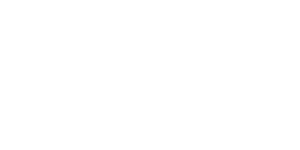

	30 centroids
	Max height guess different from Gaussian fit on average by: 1.17 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130f6b3d0>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130f6b3d0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 9.499577086032685, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.5889 sec
 2022-05-25 second deposition after noise issue/9p5 nm corral/A220527.000351.dat 2022-05-25 second deposition after noise issue/9p5 nm corral/A220527.001034.L0050.VERT radius: 9.5 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #1 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


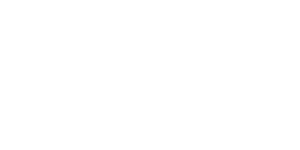

	29 centroids
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
	Max height guess different from Gaussian fit on average by: 0.63 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13103ae80>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13103ae80>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 9.031738114292345, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0537 sec
 2022-05-25 second deposition after noise issue/9 nm corral/A220527.131257.dat 2022-05-25 second deposition after noise issue/9 nm corral/A220527.132244.L0025.VERT radius: 9.0 nm,  width 17.9 mV  width sigma : 0

<IPython.core.display.Javascript object>


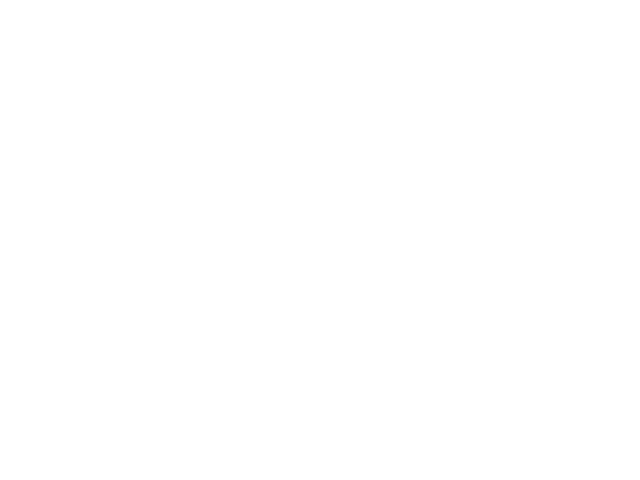

	27 centroids
	Max height guess different from Gaussian fit on average by: 0.70 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1309581f0>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1309581f0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 8.554263579459278, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.5178 sec
 2022-05-25 second deposition after noise issue/8p57 nm corral/A220527.173842.dat 2022-05-25 second deposition after noise issue/8p57 nm corral/A220527.174243.L0024.VERT radius: 8.6 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #3 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


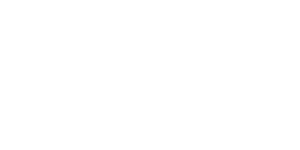

	26 centroids
	Max height guess different from Gaussian fit on average by: 0.72 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13094be80>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13094be80>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 8.05368497318872, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0599 sec
 2022-05-25 second deposition after noise issue/8p08 nm corral/A220527.185403.dat 2022-05-25 second deposition after noise issue/8p08 nm corral/A220527.185837.L0024.VERT radius: 8.1 nm,  width 16.5 mV  width sigma : 0.0 mV 
ANALYZING (zero-indexed) ELEMENT #4 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


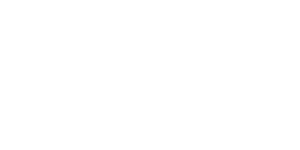

	25 centroids
	Max height guess different from Gaussian fit on average by: 1.05 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130f83cd0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130f83cd0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 7.505584662605479, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0498 sec
 2022-05-25 second deposition after noise issue/7p5 nm corral/A220527.212711.dat 2022-05-25 second deposition after noise issue/7p5 nm corral/A220527.214240.L0025.VERT radius: 7.5 nm,  width 16.3 mV  width sigma : 0.0 mV 
ANALYZING (zero-indexed) ELEMENT #5 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


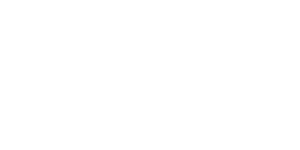

	31 centroids
	Max height guess different from Gaussian fit on average by: 1.01 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1311485e0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1311485e0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 8.021247529733117, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0330 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/8 nm/A220524.132718.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/8 nm/A220524.133236.L0020.VERT radius: 8.0 nm,  width 14.2 mV  width sigma : 0.0 mV 
ANALYZING (zero-indexed) ELEMENT #6 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


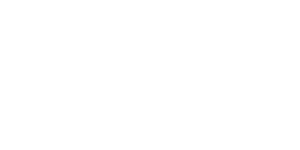

	28 centroids
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
	Max height guess different from Gaussian fit on average by: 0.57 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131457880>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131457880>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 7.410579176617864, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0381 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/7.3 nm corral/A220523.182042.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/7.3 nm corral/A220523.182756.L0020.VERT radius: 7.4 nm,  width 22.3 mV  width sigma : 0.1 mV 
ANALYZING (zero-indexed) ELEMENT #7 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


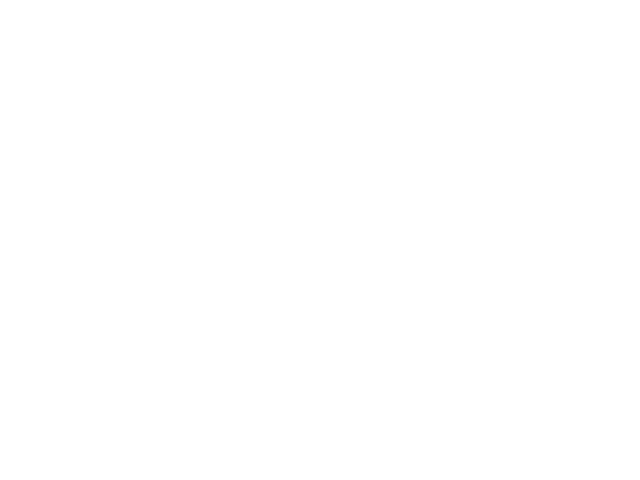

	28 centroids
	Max height guess different from Gaussian fit on average by: 0.57 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13146ed30>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13146ed30>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.965969158754547, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0723 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/7 nm corral/A220523.234720.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/7 nm corral/A220523.235603.L0020.VERT radius: 7.0 nm,  width 22.6 mV  width sigma : 0.4 mV 
ANALYZING (zero-indexed) ELEMENT #8 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


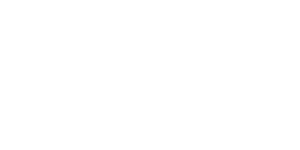

	22 centroids
	Max height guess different from Gaussian fit on average by: 0.80 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131388be0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131388be0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.040092980208288, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0576 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6p07 nm Monday corral/A220523.145912.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6p07 nm Monday corral/A220523.150635.L0020.VERT radius: 6.0 nm,  width 29.5 mV  width sigma : 1.8 mV 
ANALYZING (zero-indexed) ELEMENT #9 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


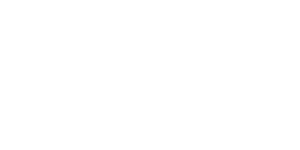

	28 centroids
	Max height guess different from Gaussian fit on average by: 0.63 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13144fdc0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13144fdc0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.671892987156009, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0921 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6.7 nm corral/A220524.015654.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6.7 nm corral/A220524.020013.L0020.VERT radius: 6.7 nm,  width 36.7 mV  width sigma : 0.7 mV 
ANALYZING (zero-indexed) ELEMENT #10 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


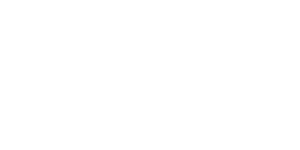

	27 centroids
	Max height guess different from Gaussian fit on average by: 0.55 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13146eee0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13146eee0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.288775953885645, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0850 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6.3nm corral/A220524.094612.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6.3nm corral/A220524.095007.L0020.VERT radius: 6.3 nm,  width 50.0 mV  width sigma : 21.8 mV 
ANALYZING (zero-indexed) ELEMENT #11 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


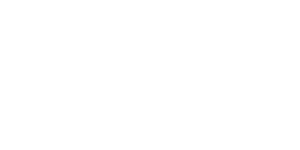

	27 centroids
	Max height guess different from Gaussian fit on average by: 0.53 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13098d1f0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13098d1f0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.107313408362669, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0641 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6.1nm radius corral/A220524.105814.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6.1nm radius corral/A220524.110432.L0020.VERT radius: 6.1 nm,  width 42.2 mV  width sigma : 4.0 mV 
ANALYZING (zero-indexed) ELEMENT #12 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


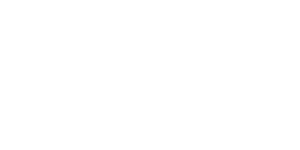

	23 centroids
	Max height guess different from Gaussian fit on average by: 0.81 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13099bc10>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13099bc10>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 5.58681698434952, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0640 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/5p5 nm corral/A220522.235140.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/5p5 nm corral/A220522.235730.L0030.VERT radius: 5.6 nm,  width 27.5 mV  width sigma : 0.9 mV 
ANALYZING (zero-indexed) ELEMENT #13 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


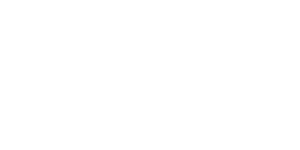

	24 centroids
	Max height guess different from Gaussian fit on average by: 0.70 Å
Something went wrong removing central atom
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/AaltoAtoms/utils/find_atom_positions.py", line 683, in get_corral_radius
    atoms_n, center_atom_loc = self.remove_central_atom(array(self.centroids))
  File "/usr/local/lib/python3.8/site-packages/AaltoAtoms/utils/find_atom_positions.py", line 248, in remove_central_atom
    raise Exception("Something went wrong removing central atom")
Exception: Something went wrong removing central atom

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1308caf70>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1308caf70>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'sav

<IPython.core.display.Javascript object>


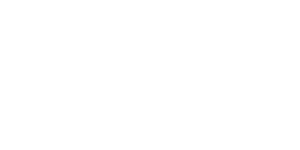

	18 centroids
	Max height guess different from Gaussian fit on average by: 0.49 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1309e3a00>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1309e3a00>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 4.5267511496032515, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.5679 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/4p5 nm corral/A220520.142331.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/4p5 nm corral/A220520.142629.L0030.VERT radius: 4.5 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #15 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


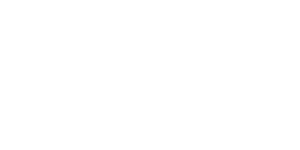

	18 centroids
	Max height guess different from Gaussian fit on average by: 0.33 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13073c250>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x13073c250>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 4.10655233490079, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.1200 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/4 nm corral/A220518.151648.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/4 nm corral/A220518.153129.L0030.VERT radius: 4.1 nm,  width 23.5 mV  width sigma : 0.1 mV 
ANALYZING (zero-indexed) ELEMENT #16 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


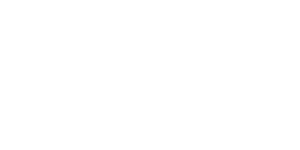

	17 centroids
	Max height guess different from Gaussian fit on average by: 0.38 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130973820>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130973820>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 3.567282060286531, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.5422 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/3p5nm corral/A220518.181143.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/3p5nm corral/A220518.182241.L0025.VERT radius: 3.6 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #17 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


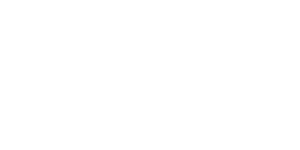

	15 centroids
	Max height guess different from Gaussian fit on average by: 0.33 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130973670>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130973670>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 3.6063752326619998, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0599 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/3nm radius/A220519.211852.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/3nm radius/A220519.213027.L0016.VERT radius: 3.6 nm,  width 47.7 mV  width sigma : 11.8 mV 
ANALYZING (zero-indexed) ELEMENT #18 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


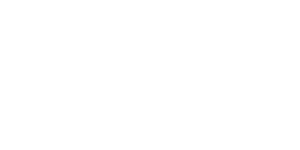

	15 centroids
	Max height guess different from Gaussian fit on average by: 0.30 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12fd7f460>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12fd7f460>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 3.9302777510084126, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.5624 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/3.93 nm radius corral/A220520.094659.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/3.93 nm radius corral/A220520.095212.L0015.VERT radius: 3.9 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #0 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


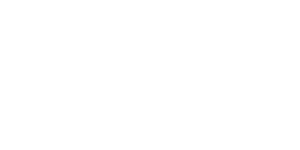

	30 centroids
	Max height guess different from Gaussian fit on average by: 1.17 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10d0db9d0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x10d0db9d0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 9.499577086032685, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0734 sec
 2022-05-25 second deposition after noise issue/9p5 nm corral/A220527.000351.dat 2022-05-25 second deposition after noise issue/9p5 nm corral/A220527.001034.L0045.VERT radius: 9.5 nm,  width 28.2 mV  width sigma : 2.0 mV 
ANALYZING (zero-indexed) ELEMENT #1 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


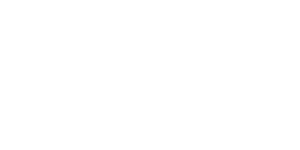

	29 centroids
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
	Max height guess different from Gaussian fit on average by: 0.63 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12ebbda60>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12ebbda60>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 9.031738114292345, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.7368 sec
 2022-05-25 second deposition after noise issue/9 nm corral/A220527.131257.dat 2022-05-25 second deposition aft

<IPython.core.display.Javascript object>


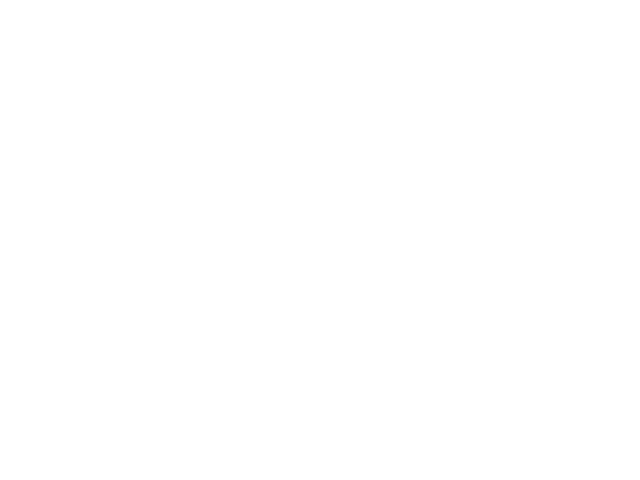

	27 centroids
	Max height guess different from Gaussian fit on average by: 0.70 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130499850>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130499850>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 8.554263579459278, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.8438 sec
 2022-05-25 second deposition after noise issue/8p57 nm corral/A220527.173842.dat 2022-05-25 second deposition after noise issue/8p57 nm corral/A220527.174243.L0020.VERT radius: 8.6 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #3 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


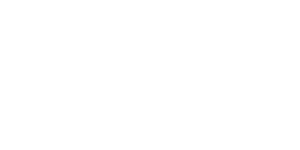

	26 centroids
	Max height guess different from Gaussian fit on average by: 0.72 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1301712b0>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1301712b0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 8.05368497318872, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0765 sec
 2022-05-25 second deposition after noise issue/8p08 nm corral/A220527.185403.dat 2022-05-25 second deposition after noise issue/8p08 nm corral/A220527.185837.L0019.VERT radius: 8.1 nm,  width 16.0 mV  width sigma : 0.0 mV 
ANALYZING (zero-indexed) ELEMENT #4 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


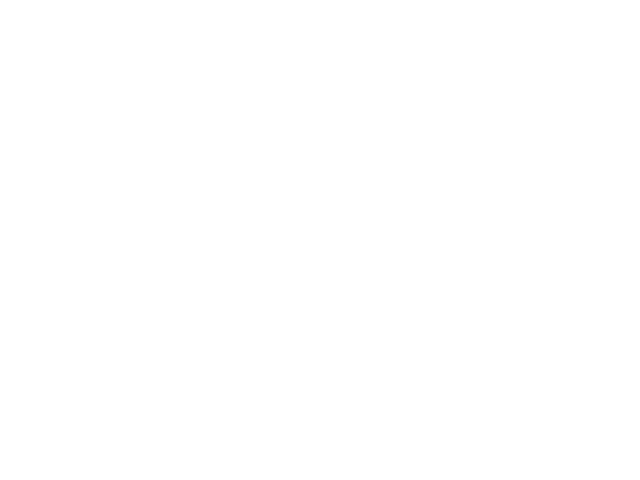

	25 centroids
	Max height guess different from Gaussian fit on average by: 1.05 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1307030d0>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1307030d0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 7.505584662605479, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.7868 sec
 2022-05-25 second deposition after noise issue/7p5 nm corral/A220527.212711.dat 2022-05-25 second deposition after noise issue/7p5 nm corral/A220527.214240.L0019.VERT radius: 7.5 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #5 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


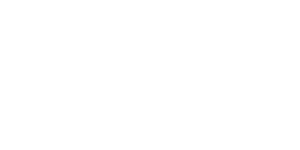

	31 centroids
	Max height guess different from Gaussian fit on average by: 1.01 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e92e910>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e92e910>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 8.021247529733117, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.7762 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/8 nm/A220524.132718.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/8 nm/A220524.133236.L0023.VERT radius: 8.0 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #6 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


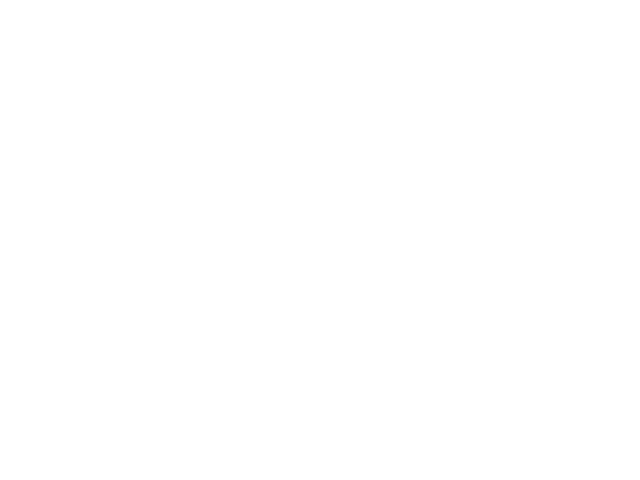

	28 centroids
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
zero-size array to reduction operation maximum which has no identity
trying with smaller box size
	Max height guess different from Gaussian fit on average by: 0.57 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1306d2df0>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1306d2df0>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 7.410579176617864, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.6965 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/7.3 nm corral/A220523.182042.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/7.3 nm corral/A220523.182756.L0015.VERT radius: 7.4 nm,  width nan mV  width sigma : nan mV 
ANALYZIN

<IPython.core.display.Javascript object>


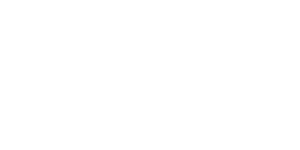

	28 centroids
	Max height guess different from Gaussian fit on average by: 0.57 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e5f4580>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e5f4580>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.965969158754547, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.6485 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/7 nm corral/A220523.234720.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/7 nm corral/A220523.235603.L0017.VERT radius: 7.0 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #8 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


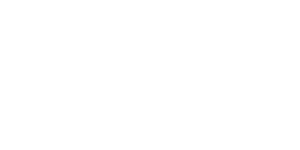

	22 centroids
	Max height guess different from Gaussian fit on average by: 0.80 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e106d00>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e106d00>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.040092980208288, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.6999 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6p07 nm Monday corral/A220523.145912.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6p07 nm Monday corral/A220523.150635.L0016.VERT radius: 6.0 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #9 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


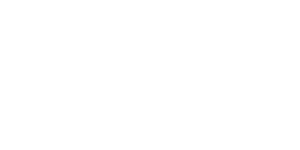

	28 centroids
	Max height guess different from Gaussian fit on average by: 0.63 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130985c70>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130985c70>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.671892987156009, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0731 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6.7 nm corral/A220524.015654.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6.7 nm corral/A220524.084536.L0014.VERT radius: 6.7 nm,  width 26.0 mV  width sigma : 3.7 mV 
ANALYZING (zero-indexed) ELEMENT #10 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


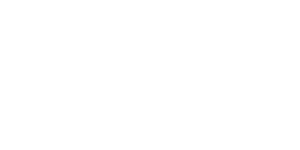

	27 centroids
	Max height guess different from Gaussian fit on average by: 0.55 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e409c70>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e409c70>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.288775953885645, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0269 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6.3nm corral/A220524.094612.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6.3nm corral/A220524.095007.L0016.VERT radius: 6.3 nm,  width 18.4 mV  width sigma : 8.1 mV 
ANALYZING (zero-indexed) ELEMENT #11 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


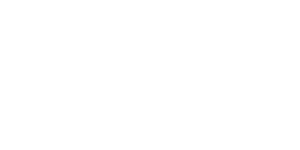

	27 centroids
	Max height guess different from Gaussian fit on average by: 0.53 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e678700>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e678700>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 6.107313408362669, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0687 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/6.1nm radius corral/A220524.105814.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/6.1nm radius corral/A220524.110432.L0023.VERT radius: 6.1 nm,  width 50.0 mV  width sigma : 509.9 mV 
ANALYZING (zero-indexed) ELEMENT #12 of 19 IN ARRAY:


<IPython.core.display.Javascript object>


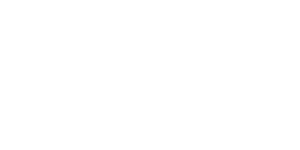

	23 centroids
	Max height guess different from Gaussian fit on average by: 0.81 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e678490>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e678490>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 5.58681698434952, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.0308 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/5p5 nm corral/A220522.235140.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/5p5 nm corral/A220522.235730.L0026.VERT radius: 5.6 nm,  width 27.6 mV  width sigma : 3.6 mV 
ANALYZING (zero-indexed) ELEMENT #13 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


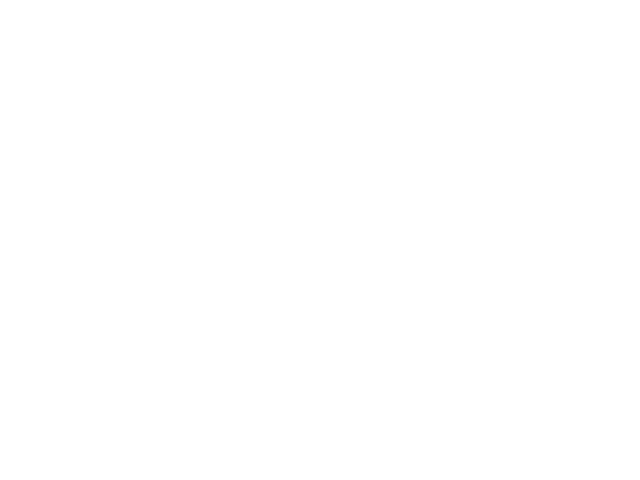

	24 centroids
	Max height guess different from Gaussian fit on average by: 0.70 Å
Something went wrong removing central atom
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/AaltoAtoms/utils/find_atom_positions.py", line 683, in get_corral_radius
    atoms_n, center_atom_loc = self.remove_central_atom(array(self.centroids))
  File "/usr/local/lib/python3.8/site-packages/AaltoAtoms/utils/find_atom_positions.py", line 248, in remove_central_atom
    raise Exception("Something went wrong removing central atom")
Exception: Something went wrong removing central atom

func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130637940>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130637940>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'sav

<IPython.core.display.Javascript object>


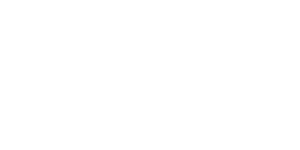

	18 centroids
	Max height guess different from Gaussian fit on average by: 0.49 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131388c70>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x131388c70>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 4.5267511496032515, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.8211 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/4p5 nm corral/A220520.142331.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/4p5 nm corral/A220520.142629.L0026.VERT radius: 4.5 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #15 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


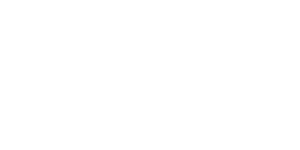

	18 centroids
	Max height guess different from Gaussian fit on average by: 0.33 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130885a60>, None), {}] 
		took: 0.0000 sec
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130885a60>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 4.10655233490079, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.1583 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/4 nm corral/A220518.151648.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/4 nm corral/A220518.153129.L0026.VERT radius: 4.1 nm,  width 25.3 mV  width sigma : 0.2 mV 
ANALYZING (zero-indexed) ELEMENT #16 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


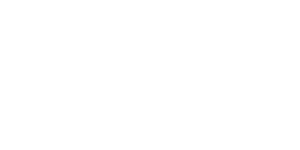

	17 centroids
	Max height guess different from Gaussian fit on average by: 0.38 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1306e4430>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x1306e4430>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 3.567282060286531, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.7536 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/3p5nm corral/A220518.181143.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/3p5nm corral/A220518.182241.L0020.VERT radius: 3.6 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #17 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


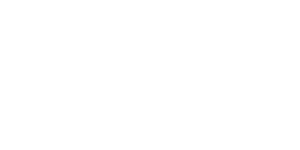

	15 centroids
	Max height guess different from Gaussian fit on average by: 0.33 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130637820>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x130637820>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 3.6063752326619998, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.6352 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/3nm radius/A220519.211852.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/3nm radius/A220519.213027.L0020.VERT radius: 3.6 nm,  width nan mV  width sigma : nan mV 
ANALYZING (zero-indexed) ELEMENT #18 of 19 IN ARRAY:
using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


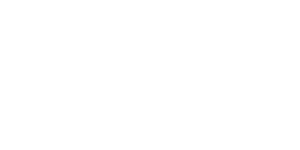

	15 centroids
	Max height guess different from Gaussian fit on average by: 0.30 Å
func: 'remove_background'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e6e1e20>, None), {}] 
		took: 0.0000 sec
Optimal parameters not found: The maximum number of function evaluations is exceeded.
did not fit!!
func: 'fit_fano'
	args: [(<AaltoAtoms.Kondo_data_analysis.read_vertfile.Spec object at 0x12e6e1e20>,), {'marker1': -20, 'marker2': 20, 'showfig': False, 'savefig': False, 'actual_radius': 3.9302777510084126, 'type_fit': 'default', 'e0_fixed_val': nan}] 
		took: 0.6709 sec
 2022-05-16 H2Pc (2 min 300 C -130 C)/3.93 nm radius corral/A220520.094659.dat 2022-05-16 H2Pc (2 min 300 C -130 C)/3.93 nm radius corral/A220520.095212.L0009.VERT radius: 3.9 nm,  width nan mV  width sigma : nan mV 


In [23]:
H2Pc_center = analyze_data(H2Pc_corrals_center)
H2Pc_edge = analyze_data(H2Pc_corrals_edge)

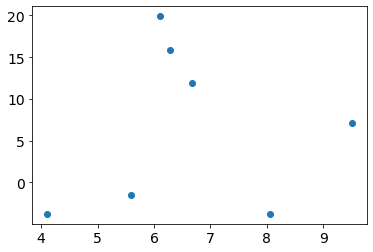

In [20]:
plt.scatter([h['radius'] for h in H2Pc_edge], [h['fano_fit_result'][0][0] for h in H2Pc_edge])

In [25]:
H2Pc_edge = sorted([h for h in H2Pc_edge], key = lambda h: h['radius'])

In [198]:
for m, p in enumerate(list(zip(peaks, props))):
    print(h['bias_mv'][p[0]])

## Trying to algorithmically find peak locations in spectra and fit 'radius offset' and E0 using particle-in-a-box modes equation

<IPython.core.display.Javascript object>


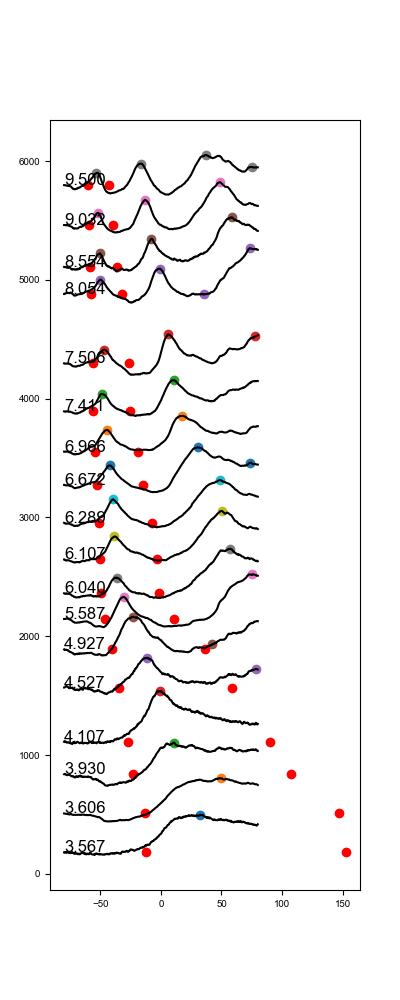

In [26]:
### THIS WORKS FOR cleaning H2PC center data!!!
plt.figure(figsize=(4,10))
peakslist = {}
mult = 300
l0 = lambda x, ms, e0: get_modes(ms*scipy.constants.electron_mass, e0, (np.array(x)-ms)*1e-9, 2).T[0]*1000
l1 = lambda x, ms, e0: get_modes(ms*scipy.constants.electron_mass, e0, (np.array(x)-ms)*1e-9, 2).T[1]*1000

for n, h  in enumerate(list(sorted(H2Pc_center, key=lambda x: x['radius']))):
    if np.isclose(8.02, h['radius'],0.001):
        pass
    else:
        plt.plot(h['bias_mv'], h['dIdV'] + 300*n, c='black')
        maxdIdV, argmax = np.max(h['dIdV']), np.argmax(h['dIdV'])
        peaks, props = find_peaks(h['dIdV'], distance=115, height=380)
        #peaks, props = find_peaks(h['dIdV'],plateau_size=2)
        peaks2 = []
        
        for n1,  p in enumerate(peaks):
            
            if h['bias_mv'][p]>-60 and h['bias_mv'][p]<79:
                peaks2.append(p)
        
        if h['radius'] < 4.9 and len(peaks2)>1:
            # remove the smallest dIdV peak
            peaks2.pop(np.argmin(h['dIdV'][peaks2]))
        plt.scatter(h['bias_mv'][peaks2], h['dIdV'][peaks2]+ mult*n )
        peakslist[h['radius']] = sorted(np.array([h['bias_mv'][peaks2], h['dIdV'][peaks2]]).T, key=lambda x: x[0])
        #e0, e1, e2, e3 = get_modes(mstar, 0.067, np.array([h['radius']])*1e-9, 4).T*1e3

        #plt.scatter(h['bias_mv'][argmax], maxdIdV+ 300*n)
        plt.text(-80, h['dIdV'][-1] + mult*n, "%1.3lf" %h['radius'], size=12)
        
        plt.scatter(l0([h['radius']], 0.4, 0.067), h['dIdV'][-1] + mult*n, c='red')
        plt.scatter(l1([h['radius']], 0.6, 0.067), h['dIdV'][-1] + mult*n, c='red')

<IPython.core.display.Javascript object>


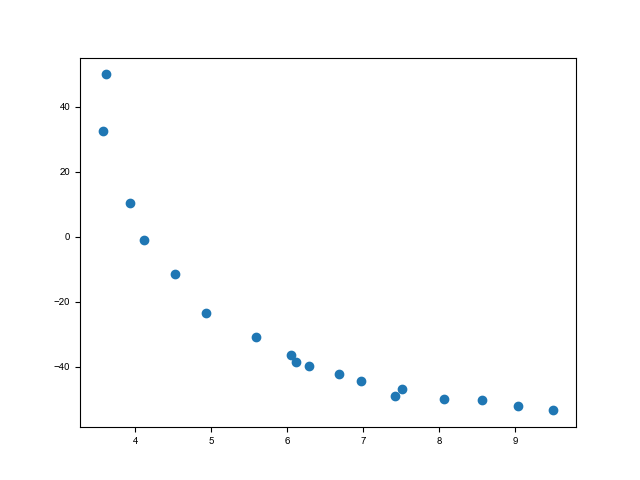

In [163]:
%matplotlib notebook
plt.scatter([s[0] for s in sorted(peakslist.items())], [s[1][0][0] for s in sorted(peakslist.items())])

In [49]:
for p in peakslist:
    if len(peakslist[p][0])<4:
        for i in range(4-len(peakslist[p][0])):
            peakslist[p][1] = np.concatenate([peakslist[p][1], [None]])
            peakslist[p][0] = np.concatenate([peakslist[p][0], [None]])
pd.DataFrame.from_records(peakslist)#.to_csv("/Users/akipnis/Desktop/H2Pc.csv")
#peakslist[p][0].append(None)

3.567282                       3.606375  \
0  [68.1836, 32.4152, None, None]   [49.98, 14.2116, None, None]   
1   [438.61, 497.111, None, None]  [504.549, 430.94, None, None]   

                         3.930278                         4.106552  \
0  [47.7445, 10.3792, None, None]  [34.3313, -1.11776, None, None]   
1   [463.836, 504.41, None, None]    [452.578, 638.74, None, None]   

                             4.526751                         4.927277  \
0  [78.4032, 25.7086, -11.3373, None]  [44.5509, -23.4731, None, None]   
1   [525.323, 422.171, 618.632, None]   [443.649, 664.717, None, None]   

                          5.586817                         6.040093  \
0  [75.5289, -30.8184, None, None]  [57.3253, -36.5669, None, None]   
1   [721.519, 530.802, None, None]   [637.234, 393.763, None, None]   

                         6.107313                         6.288776  \
0  [50.2994, -38.483, None, None]  [48.7026, -39.7605, None, None]   
1   [655.17, 439.715, None, None]    [615.75, 452.515, None, None]   

                            6.671893                         6.965969  \
0  [73.9321, 30.499, -42.3154, None]  [17.4052, -44.5509, None, None]   
1  [460.032, 590.229, 437.466, None]   [555.929, 436.799, None, None]   

                         7.410579                               7.505585  \
0   [11.018, -49.022, None, None]  [77.7645, 42.3154, 6.22754, -46.7864]   
1  [555.227, 440.861, None, None]   [624.285, 399.153, 640.719, 513.826]   

                               8.053685                             8.554264  \
0   [73.6128, 34.012, -1.11776, -49.98]  [58.6028, -7.82435, -50.2994, None]   
1  [767.318, 383.041, 595.509, 503.218]     [727.02, 547.194, 423.646, None]   

                              9.031738                                9.499577  
0  [48.7026, -13.2535, -52.2156, None]  [75.5289, 36.8862, -16.4471, -52.5349]  
1     [722.048, 574.201, 464.53, None]    [550.457, 651.353, 579.387, 501.453]

In [135]:
get_modes(ms*scipy.constants.electron_mass, e0, (np.array(x)-ms)*1e-9, 2).T[0]

NameError: name 'ms' is not defined

In [515]:
l0 = lambda x, ms, e0: get_modes(ms*scipy.constants.electron_mass, e0, (np.array(x)-ms)*1e-9, 2).T[0]*1000
#l = lambda x, ms, e0: get_modes(mstar, e0, (np.array(x)-ms)*1e-9, 2).T[mode]*1000

inp = [p for p in sorted(peakslist)], [sorted(peakslist[p])[mode][0] for p in sorted(peakslist)]
#plt.plot(*inp)
radii = [p for p in sorted(peakslist)]
res, opt = scipy.optimize.curve_fit(l0, *inp, p0 =[0.05, 0.4])
plt.plot([p for p in sorted(peakslist)], l(radii, *res))
plt.plot(radii, l(radii, 0.4, 0.067))
plt.legend(["0.18*m_e", "data", "0.4*m_e", ])
print(res)

ValueError: `ydata` must not be empty!

In [6]:
fig = imshow_dIdV_vs_r(Co_Ag_data,cmap_str='plasma', e0=0.055, radius_offset=2, ms=0.4)
r_range = np.array([11.05,10.06,9.15,8.16,7.6,7.09,6.82,6.08,5.94,5.78,5.54,5.14,4.65,3.8])
modes_list = np.array([-49,-15.6,27,-46,-8.2,47.6,-42,2.5,76.3,-35.8,20.9,np.nan,
    -30.5,33.4,np.nan,-25.5,52.2,np.nan,-22,64.9,np.nan,-11.7,np.nan,np.nan,
    -9.9,np.nan,np.nan,-1.4,np.nan,np.nan,2.5,np.nan,np.nan,7.1,np.nan,np.nan,
    22,np.nan,np.nan,73,np.nan,np.nan])
for m in modes_list.reshape(14,3).T:
    plt.scatter(m, r_range)
plt.scatter([s[1][0][0] for s in sorted(peakslist.items())], [s[0] for s in sorted(peakslist.items())])

NameError: name 'Co_Ag_data' is not defined

using channel 0 instead of channel 2!


<IPython.core.display.Javascript object>


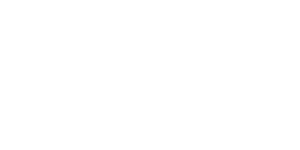

	15 centroids
	Max height guess different from Gaussian fit on average by: 0.32 Å


<IPython.core.display.Javascript object>


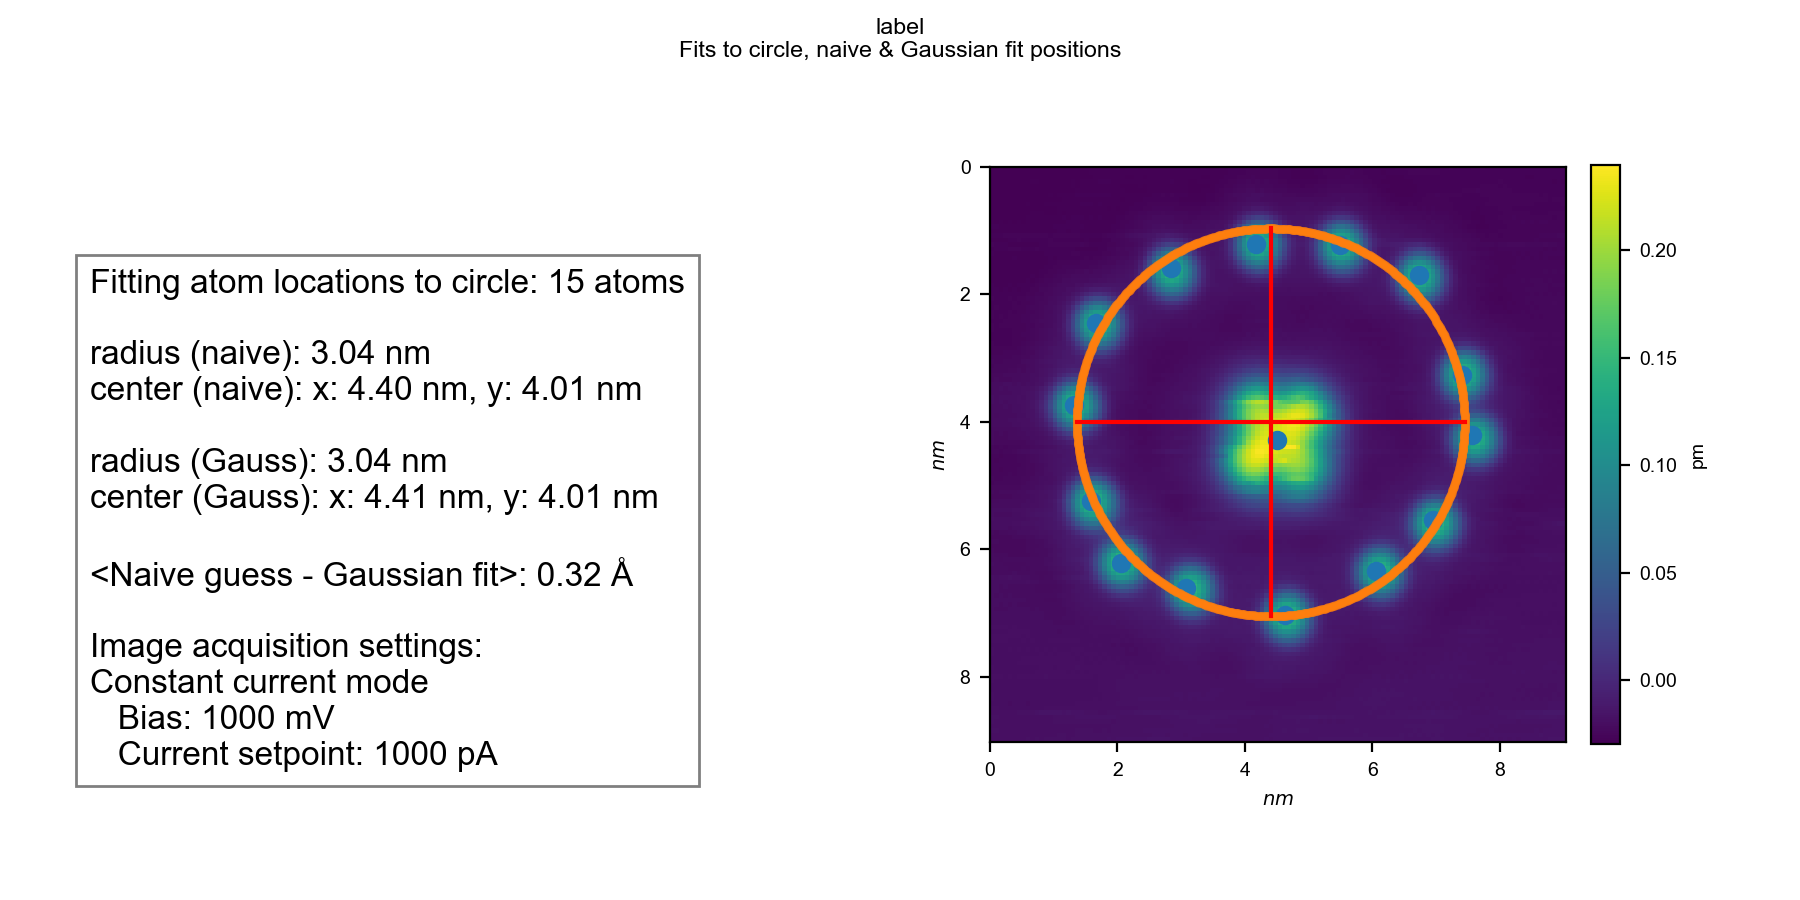

	 label
	Central atom from Naive fit:  3.0415029236230122 [62.33465086 56.78072228]
	Central atom from Gauss fit:  3.041450611757088 [62.43417481 56.84907521]


In [355]:
c = CircCorralData(r"/Users/akipnis/Desktop/H2Pc data for Abe/2022-05-16 H2Pc (2 min 300 C -130 C)/3nm radius/A220519.224552.dat", "label",)
c.occupied = True
c.corral = True
c.subtract_plane()
kwargs = {'percentile':97, 'edge_cutoff':0.1}
c.get_region_centroids(**kwargs)
radius = c.get_corral_radius(1.5, savefig=False, showfig=True)


<IPython.core.display.Javascript object>


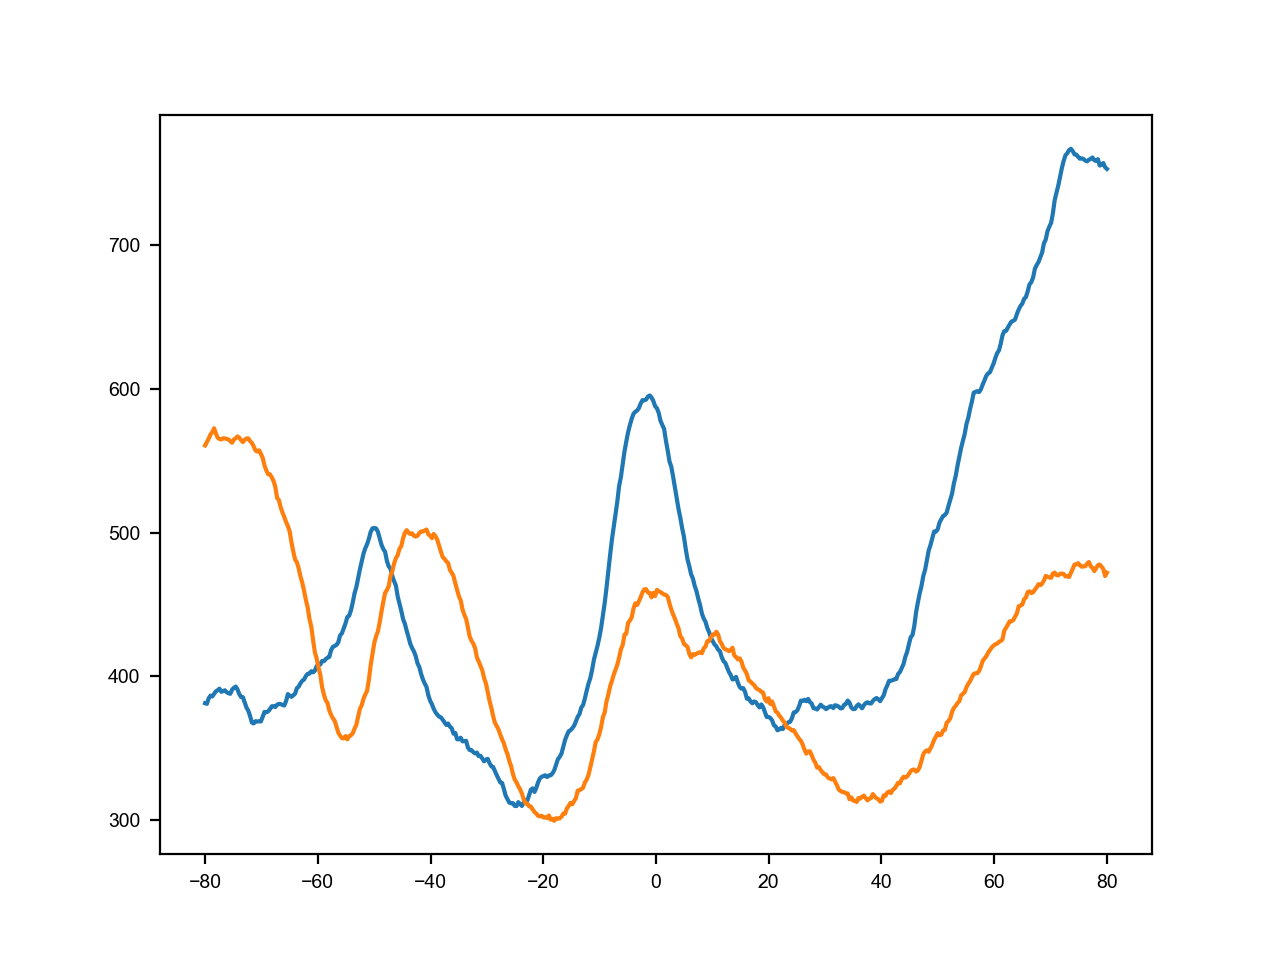

8.05368497318872
9.157616108657644


In [372]:
plt.figure()

for c in H2Pc_center[3:4]:
    print(c['radius'])
    plt.plot(c['bias_mv'], c['dIdV'])
for c in Co_Ag_data[2:3]:
    print(c['radius'])
    plt.plot(c['bias_mv'], c['dIdV'])

In [209]:
def get_mode_list_for_r_list(rad_diff, ms, e0, r_range):
    nm = 3
    modes = get_modes(ms*scipy.constants.electron_mass, e0, (r_range-rad_diff)*1e-9, 3).T
    #[m for m in modes if m<0.08]
    cleaned = []
    for r in modes.T:
        idx_list = []
        for mode_n, mode in enumerate(r):
            if mode>0.08:
                idx_list.append(mode_n)
        r_new = np.delete(r,idx_list)
        if len(r_new)<nm:
            for m in range(nm-len(r_new)):
                r_new= np.concatenate([r_new,[np.nan]])
        cleaned.append(r_new)
    return np.array(cleaned).flatten()
r_range = np.array([11.05,10.06,9.15,8.16,7.6,7.09,6.82,6.08,5.94,5.78,5.54,5.14,4.65,3.8])
modes_list = np.array([-49,-15.6,27,-46,-8.2,47.6,-42,2.5,76.3,-35.8,20.9,np.nan,
    -30.5,33.4,np.nan,-25.5,52.2,np.nan,-22,64.9,np.nan,-11.7,np.nan,np.nan,
    -9.9,np.nan,np.nan,-1.4,np.nan,np.nan,2.5,np.nan,np.nan,7.1,np.nan,np.nan,
    22,np.nan,np.nan,73,np.nan,np.nan])

def fun(vals):
    return np.sqrt(np.nansum((get_mode_list_for_r_list(vals[0], vals[1], vals[2], r_range) - modes_list)**2))
    
r= scipy.optimize.least_squares(fun, [1,0.4,0.067])


In [ ]:
get_mode_list_for_r_list(r_range, )

## Looking at the second derivative (d2I/dV2) for evidence of spin-excitations

<IPython.core.display.Javascript object>


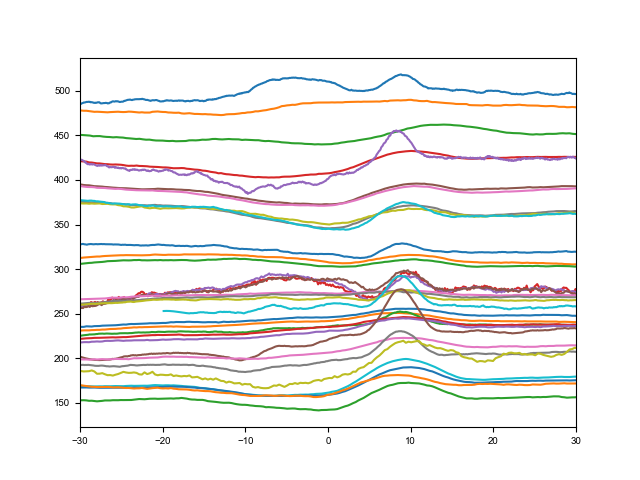

(-30.0, 30.0)

In [27]:
plt.figure()
for c in Co_Co_data:
    plt.plot(c['bias_mv'][0:-1], c['radius'] *60+ savgol_filter(np.diff(c['dIdV'])/np.diff(c['bias_mv']), 50, 3))
plt.xlim(-30,30)

<IPython.core.display.Javascript object>


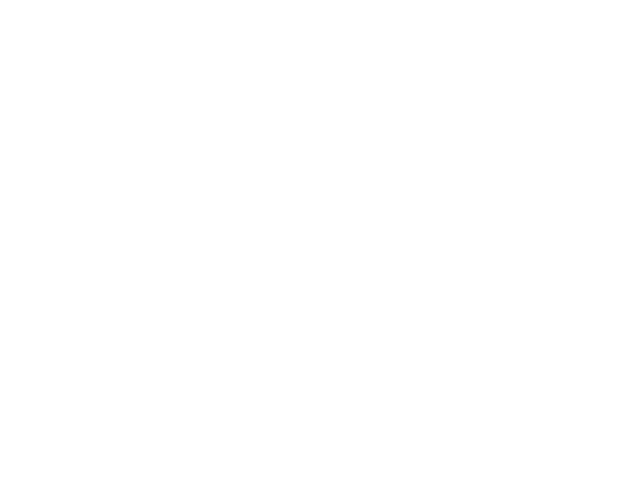

NameError: name 'Ag_waterfall_cache' is not defined

In [28]:
cm = matplotlib.colormaps['plasma']
plt.figure()
for c in Ag_waterfall_cache:
    plt.plot(c['bias'][0:-1], c['radius'] *0.1+ savgol_filter(np.diff(c['dIdV'])/np.diff(c['bias']), 15, 3),
            color=cm(c['radius']/11.))
    plt.text(-15, c['radius'] *0.1,'%1.1lf' %c['radius'])
plt.xlim(-20,20)
plt.figure()
for c in Co_waterfall_cache:
    plt.plot(c['bias'][0:-1], c['radius'] *0.1+ savgol_filter(np.diff(c['dIdV'])/np.diff(c['bias']), 25, 3),
            color=cm(c['radius']/11.))
    plt.text(-15, c['radius'] *0.1,'%1.1lf' %c['radius'])

plt.xlim(-20,20)
